<a href="https://colab.research.google.com/github/FernandoBRdgz/diplomado_ds_mod4/blob/main/4.4%20Modelado%20Secuencial/4.4.3%20Series%20de%20tiempo%20con%20RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Conjunto de Datos (Retail)

Lanzamiento: Ventas mensuales anticipadas para minoristas y servicios alimenticios

Unidades: Millones de dólares

Frecuencia: Mensual

El valor del mes más reciente es una estimación anticipada que se basa en datos de una submuestra de empresas de la Encuesta Mensual de Comercio Minorista más grande. La estimación anticipada será reemplazada en los meses siguientes por estimaciones revisadas derivadas de la Encuesta Mensual de Comercio Minorista más grande. La serie asociada de la Encuesta mensual de comercio minorista está disponible en https://fred.stlouisfed.org/series/MRTSSM448USN

Se puede encontrar información sobre la encuesta de ventas minoristas mensual anticipada en el sitio web del censo en https://www.census.gov/retail/marts/about_the_surveys.html


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
generation = "MOD4GEN<x>"

In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/{generation}/4.4 Modelado Secuencial/datasets/RSCCASN.csv', index_col='DATE', parse_dates=True)

In [ ]:
df.columns = ['Sales']

In [ ]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


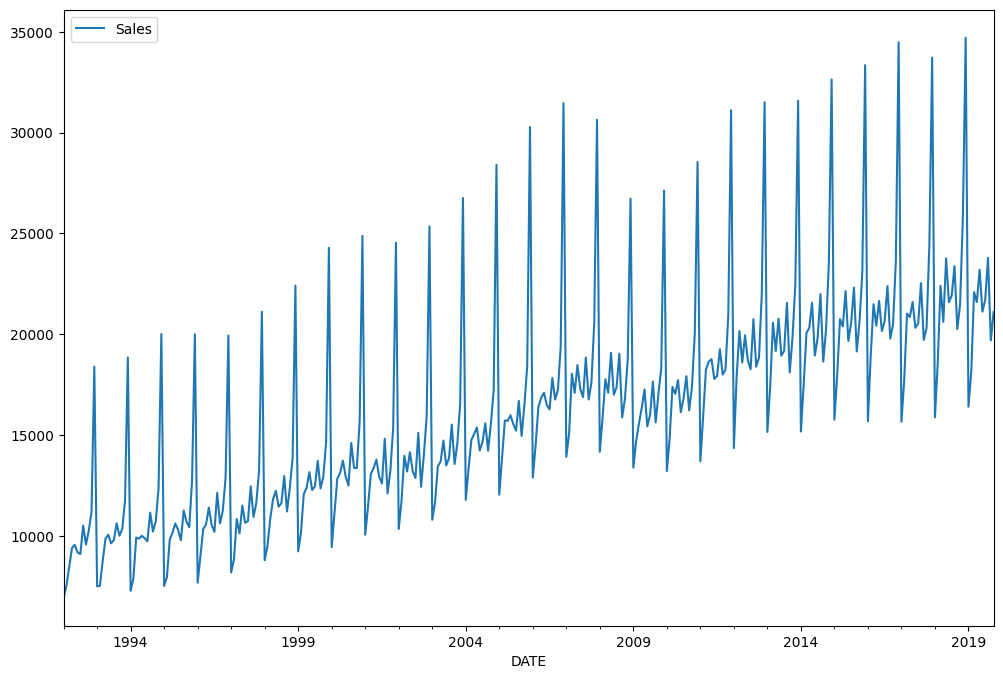

In [ ]:
df.plot(figsize=(12,8));

#### Train Test Split

In [ ]:
len(df)

334

Los datos tienen frecuencia mensual, por lo que se propone pronosticar 1 año en el futuro, es decir, 12 meses adelante.

In [ ]:
len(df)-36

298

In [ ]:
val_size = 36

In [ ]:
val_ind = len(df) - val_size

In [ ]:
train = df.iloc[:val_ind]
val = df.iloc[val_ind:]

In [ ]:
train.tail()

,Sales
DATE,
2016-06-01,20160
2016-07-01,20667
2016-08-01,22388
2016-09-01,19790
2016-10-01,20500


In [ ]:
val.head()

,Sales
DATE,
2016-11-01,23644
2016-12-01,34482
2017-01-01,15663
2017-02-01,17745
2017-03-01,21028


#### Preprocesamiento

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)

MinMaxScaler()

In [ ]:
Xs_train = scaler.transform(train)
Xs_val = scaler.transform(val)

In [ ]:
true_val = scaler.inverse_transform(Xs_val)

#### Time Series Generator

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# Se crearán ventanas de tiempo de 12 meses para luego predecir el siguiente mes
length = 12
batch_size = 1
n_features = 1

In [ ]:
generator = TimeseriesGenerator(Xs_train, Xs_train, length=length, batch_size=batch_size)
validation_generator = TimeseriesGenerator(Xs_val, Xs_val, length=length, batch_size=batch_size)

In [ ]:
X, y = generator[2]

In [ ]:
print(f'Dada la matriz X: {X.flatten()} \n')
print(f'Predecir esta y: {y}')

Dada la matriz X: [0.05820426 0.09327072 0.09921612 0.08497747 0.08198584 0.13538077
 0.09978415 0.12557276 0.16090431 0.43386223 0.02135797 0.02219109] 

Predecir esta y: [[0.06922407]]


In [ ]:
Xs_train[:15]

array([[0.        ],
       [0.02219109],
       [0.05820426],
       [0.09327072],
       [0.09921612],
       [0.08497747],
       [0.08198584],
       [0.13538077],
       [0.09978415],
       [0.12557276],
       [0.16090431],
       [0.43386223],
       [0.02135797],
       [0.02219109],
       [0.06922407]])

### Modelación

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

#### RNN

In [ ]:
from tensorflow.keras.layers import SimpleRNN

In [ ]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=100, activation='relu', input_shape=(length,n_features)))
model_rnn.add(Dense(units=1))

model_rnn.compile(optimizer='adam', loss='mse')

In [ ]:
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
model_rnn.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
286/286 [==============================] - 10s 12ms/step - loss: 0.0263 - val_loss: 0.0251
Epoch 2/20
286/286 [==============================] - 3s 11ms/step - loss: 0.0077 - val_loss: 0.0501
Epoch 3/20
286/286 [==============================] - 4s 15ms/step - loss: 0.0039 - val_loss: 0.0087
Epoch 4/20
286/286 [==============================] - 4s 15ms/step - loss: 0.0042 - val_loss: 0.0052
Epoch 5/20
286/286 [==============================] - 3s 11ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 6/20
286/286 [==============================] - 3s 12ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 7/20
286/286 [==============================] - 5s 18ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 8/20
286/286 [==============================] - 3s 11ms/step - loss: 0.0038 - val_loss: 0.0021
CPU times: user 39.5 s, sys: 3.75 s, total: 43.2 s
Wall time: 39.9 s


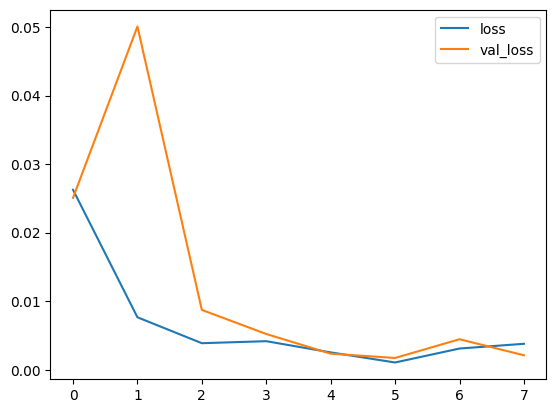

In [ ]:
losses = pd.DataFrame(model_rnn.history.history)
losses.plot();

In [ ]:
val_predictions = []

first_eval_batch = Xs_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(val)):

    # Obtiene la primera predicción por delante ([0] es para tomar solo el elemento en lugar del arreglo)
    current_pred = model_rnn.predict(current_batch)[0]

    # Almacena predicción
    val_predictions.append(current_pred)

    # Actualiza el lote para incluir la predicción y eliminar el primer valor
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 22ms/step


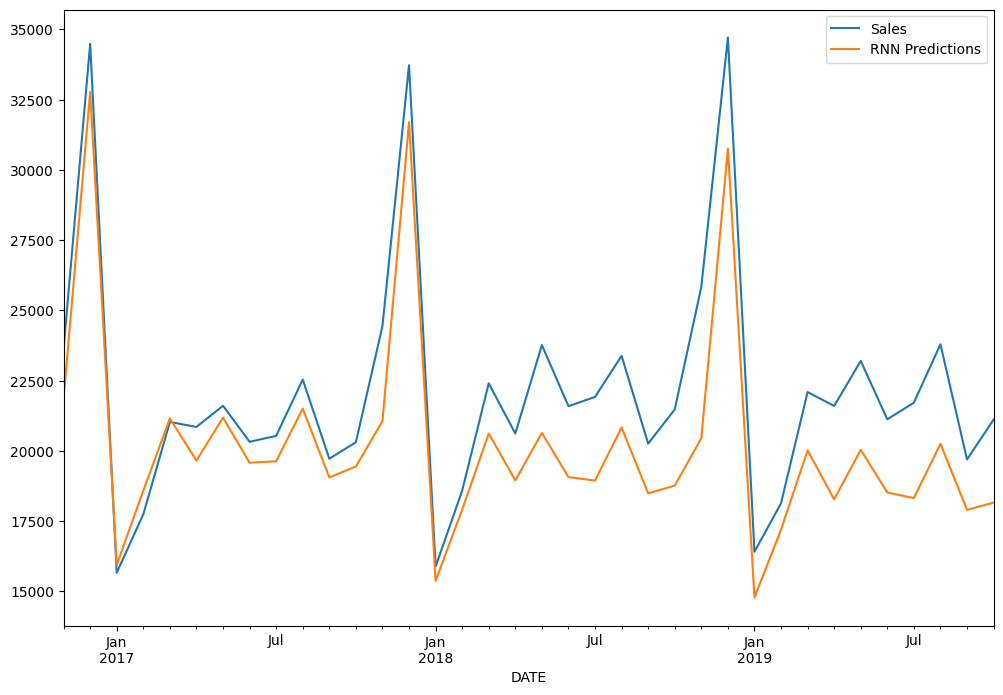

In [ ]:
true_predictions = scaler.inverse_transform(val_predictions)
val['RNN Predictions'] = true_predictions
val.plot(figsize=(12,8));

In [ ]:
print(f"MSE: {mean_squared_error(y_true=true_val, y_pred=true_predictions)}")
print(f"MAE: {mean_absolute_error(y_true=true_val, y_pred=true_predictions)}")
print(f"R2: {r2_score(y_true=true_val, y_pred=true_predictions)}")

MSE: 5346914.2473790385
MAE: 1971.9593477422995
R2: 0.7123370453394025


#### LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu', input_shape=(length,n_features)))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
model_lstm.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
286/286 [==============================] - 11s 32ms/step - loss: 0.0271 - val_loss: 0.0308
Epoch 2/20
286/286 [==============================] - 8s 27ms/step - loss: 0.0191 - val_loss: 0.0440
Epoch 3/20
286/286 [==============================] - 7s 23ms/step - loss: 0.0160 - val_loss: 0.0124
Epoch 4/20
286/286 [==============================] - 9s 31ms/step - loss: 0.0101 - val_loss: 0.0049
Epoch 5/20
286/286 [==============================] - 7s 23ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 6/20
286/286 [==============================] - 9s 31ms/step - loss: 0.0026 - val_loss: 0.0061
CPU times: user 1min 2s, sys: 6.45 s, total: 1min 9s
Wall time: 52.5 s


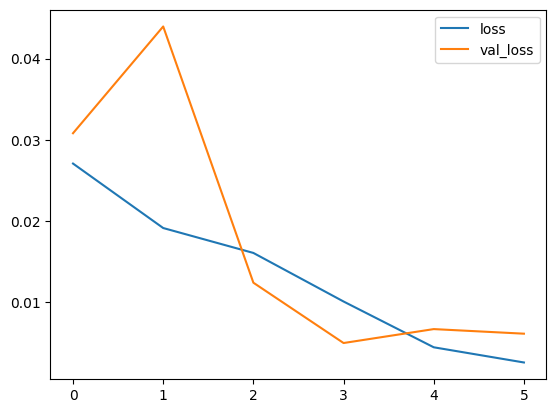

In [ ]:
losses = pd.DataFrame(model_lstm.history.history)
losses.plot();

In [ ]:
val_predictions = []

first_eval_batch = Xs_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(val)):

    # Obtiene la primera predicción por delante ([0] es para tomar solo el elemento en lugar del arreglo)
    current_pred = model_lstm.predict(current_batch)[0]

    # Almacena predicción
    val_predictions.append(current_pred)

    # Actualiza el lote para incluir la predicción y eliminar el primer valor
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 29ms/step


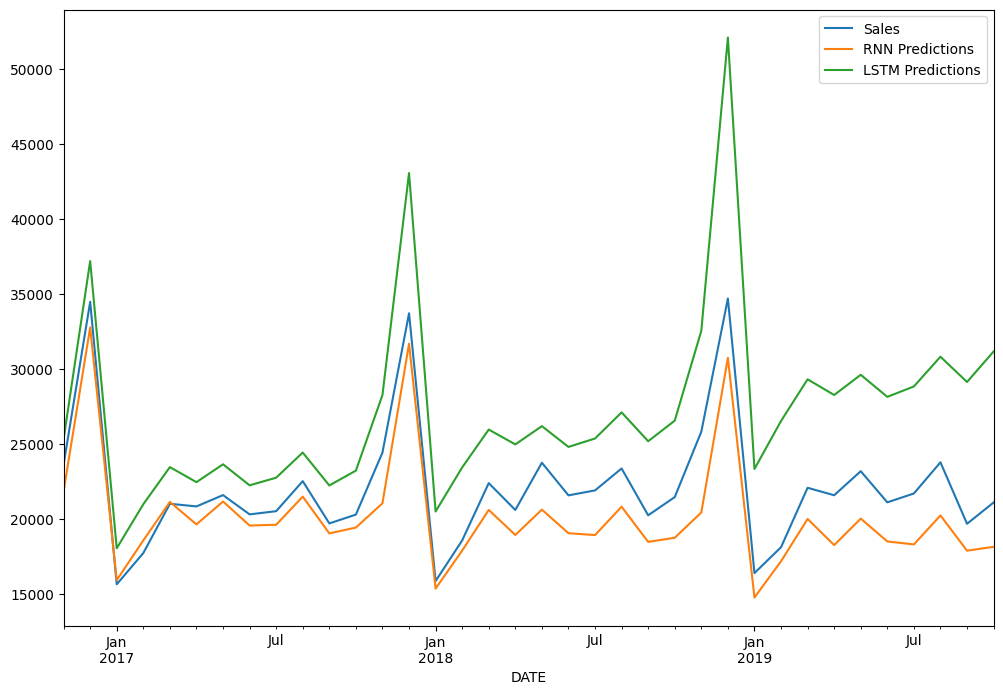

In [ ]:
true_predictions = scaler.inverse_transform(val_predictions)
val['LSTM Predictions'] = true_predictions
val.plot(figsize=(12,8));

In [ ]:
print(f"MSE: {mean_squared_error(y_true=true_val, y_pred=true_predictions)}")
print(f"MAE: {mean_absolute_error(y_true=true_val, y_pred=true_predictions)}")
print(f"R2: {r2_score(y_true=true_val, y_pred=true_predictions)}")

MSE: 35634786.81874292
MAE: 5047.16770501352
R2: -0.9171446540413226


#### GRU

In [ ]:
from tensorflow.keras.layers import GRU

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(100, activation='relu', input_shape=(length,n_features)))
model_gru.add(Dense(1))

model_gru.compile(optimizer='adam', loss='mse')

In [ ]:
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100)               30900     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
model_gru.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
286/286 [==============================] - 13s 39ms/step - loss: 0.0282 - val_loss: 0.0389
Epoch 2/20
286/286 [==============================] - 11s 37ms/step - loss: 0.0217 - val_loss: 0.0324
Epoch 3/20
286/286 [==============================] - 9s 33ms/step - loss: 0.0190 - val_loss: 0.0307
Epoch 4/20
286/286 [==============================] - 9s 31ms/step - loss: 0.0129 - val_loss: 0.0088
Epoch 5/20
286/286 [==============================] - 11s 37ms/step - loss: 0.0058 - val_loss: 0.0016
Epoch 6/20
286/286 [==============================] - 9s 31ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 7/20
286/286 [==============================] - 10s 36ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/20
286/286 [==============================] - 11s 38ms/step - loss: 0.0016 - val_loss: 9.9787e-04
Epoch 9/20
286/286 [==============================] - 10s 35ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 10/20
286/286 [==============================] - 9s 31ms/step - loss: 0.001

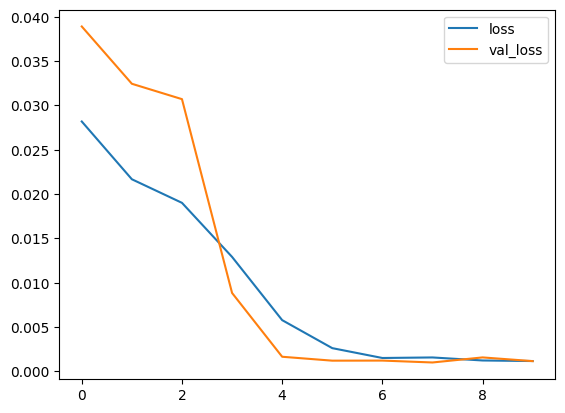

In [ ]:
losses = pd.DataFrame(model_gru.history.history)
losses.plot();

In [ ]:
val_predictions = []

first_eval_batch = Xs_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(val)):

    # Obtiene la primera predicción por delante ([0] es para tomar solo el elemento en lugar del arreglo)
    current_pred = model_gru.predict(current_batch)[0]

    # Almacena predicción
    val_predictions.append(current_pred)

    # Actualiza el lote para incluir la predicción y eliminar el primer valor
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 35ms/step


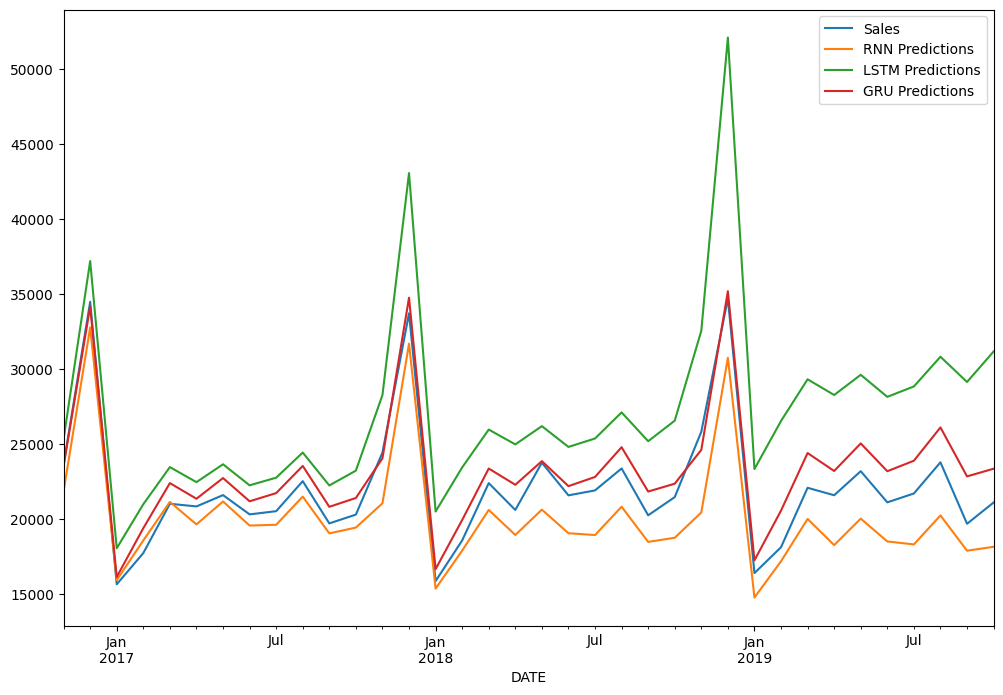

In [ ]:
true_predictions = scaler.inverse_transform(val_predictions)
val['GRU Predictions'] = true_predictions
val.plot(figsize=(12,8));

In [ ]:
print(f"MSE: {mean_squared_error(y_true=true_val, y_pred=true_predictions)}")
print(f"MAE: {mean_absolute_error(y_true=true_val, y_pred=true_predictions)}")
print(f"R2: {r2_score(y_true=true_val, y_pred=true_predictions)}")

MSE: 2095700.66046588
MAE: 1260.3345626244943
R2: 0.8872517088955953


#### Forecasting

In [ ]:
length = 12
batch_size = 1

In [ ]:
forecast = []

first_eval_batch = Xs_val[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):

    current_pred = model_gru.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 26ms/step


In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
len(forecast)

12

In [ ]:
val.tail()

,Sales,RNN Predictions,LSTM Predictions,GRU Predictions
DATE,,,,
2019-06-01,21123,18518.078290,28151.905307,23196.823125
2019-07-01,21714,18320.613074,28844.379318,23895.837022
2019-08-01,23791,20251.455085,30825.533595,26114.910946
2019-09-01,19695,17902.194139,29141.715130,22853.182399
2019-10-01,21113,18160.601495,31172.249877,23362.689122


In [ ]:
forecast_index = pd.date_range(start='2019-11-01', periods=length, freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

In [ ]:
forecast_df

,Forecast
2019-11-01,26190.085798
2019-12-01,35191.571130
2020-01-01,16851.816784
2020-02-01,18989.064217
2020-03-01,23057.206390
2020-04-01,22527.426806
2020-05-01,24358.500530
2020-06-01,22115.462763
2020-07-01,22791.406838
2020-08-01,25105.901716


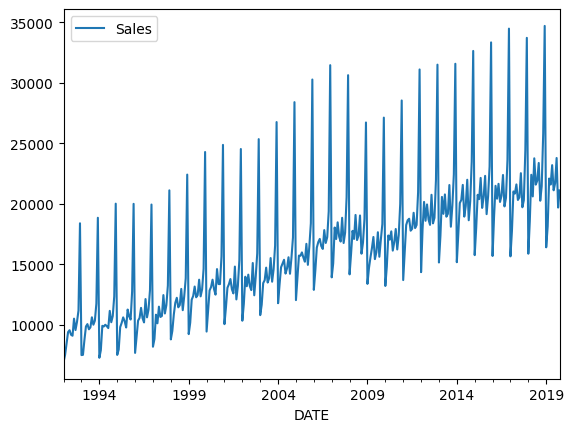

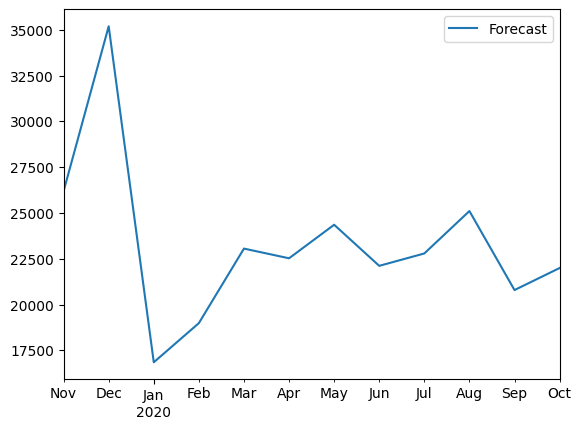

In [ ]:
df.plot()
forecast_df.plot();

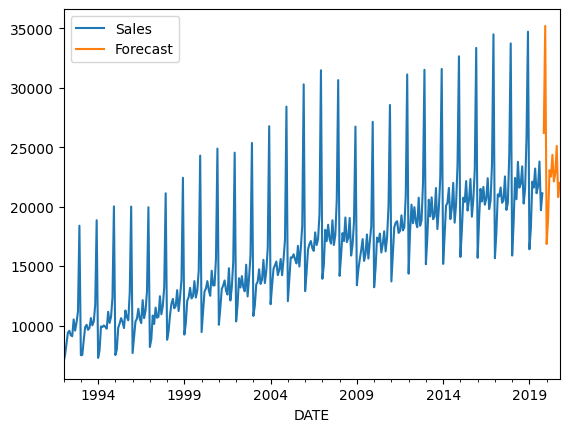

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax);

(573.0, 609.0)

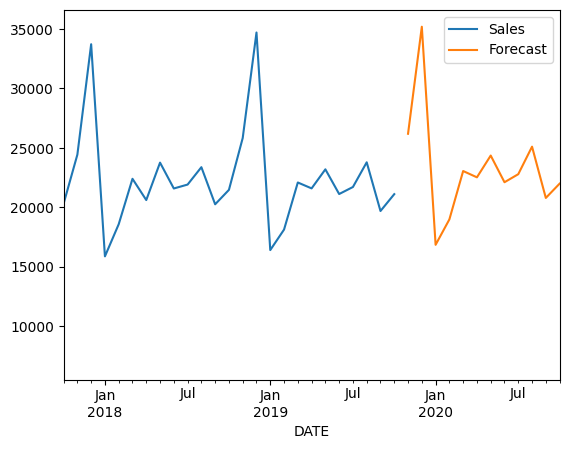

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2017-10-01', '2020-10-01')